**This file contains the code for basic EDA,Feature-Engineering Feature-Selection and Hyperparamter Tuning for registered users**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install dython

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from dython import nominal
import pickle
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pip install lofo-importance

In [ ]:
pip install optuna

In [ ]:
import optuna
from lofo import LOFOImportance,Dataset,plot_importance
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import xgboost
import lightgbm
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

**Loading the data**

In [ ]:
train_df=pd.read_csv('/content/drive/MyDrive/train_bk.csv')

In [ ]:
train_df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [ ]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


**Converting datetime object to pandas datetime and adding basic time features such as hour month year etc**

In [ ]:
train_df['datetime']=pd.to_datetime(train_df['datetime'])

In [ ]:
train_df['hour']=train_df['datetime'].dt.hour
train_df['month']=train_df['datetime'].dt.month
train_df['year']=train_df['datetime'].dt.year
train_df['day']=train_df['datetime'].dt.day
train_df['weekday']=train_df['datetime'].dt.weekday

**Starting of basic EDA**

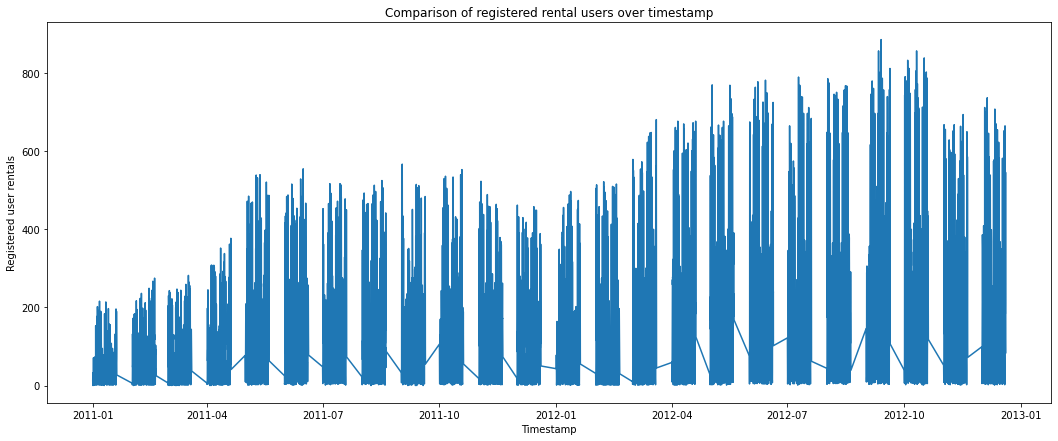

In [ ]:
fig,ax=plt.subplots(figsize=(18,7))
ax.plot(train_df['datetime'],train_df['registered'])
plt.xlabel('Timestamp')
plt.ylabel('Registered user rentals')
plt.title('Comparison of registered rental users over timestamp')
plt.show()

**The above plot shows the regsitered rental users ove rthe timestamp.From the above plot we can see that there is an increasing trend over the years**

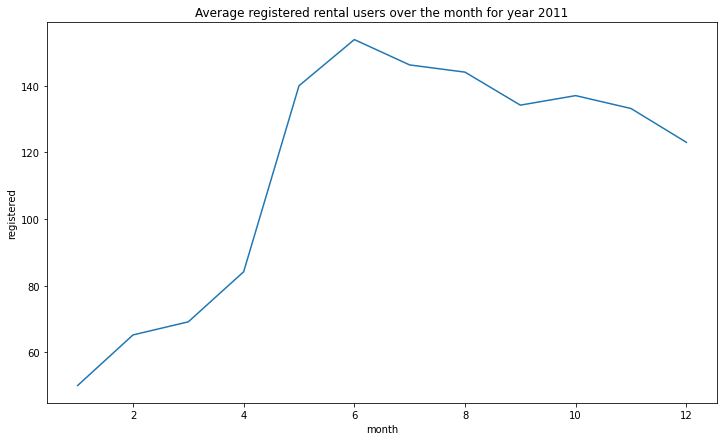

In [ ]:
fig,ax=plt.subplots(figsize=(12,7))
z=train_df.groupby(['year','month'])['registered'].mean().reset_index()
sns.lineplot(data=z[z['year']==2011],x='month',y='registered',ax=ax)
plt.title('Average registered rental users over the month for year 2011')
plt.show()

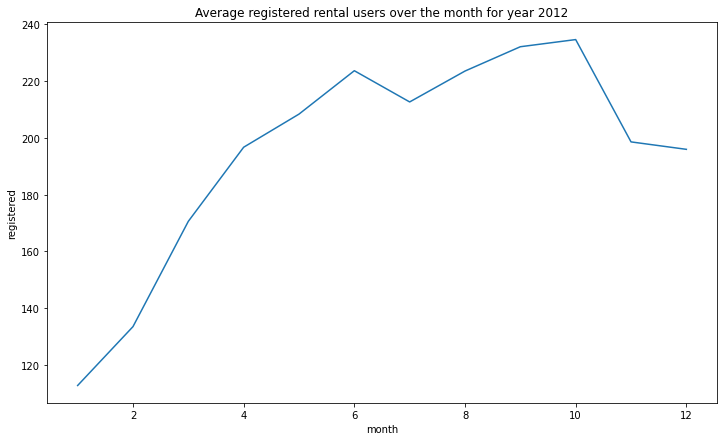

In [ ]:
fig,ax=plt.subplots(figsize=(12,7))
z=train_df.groupby(['year','month'])['registered'].mean().reset_index()
sns.lineplot(data=z[z['year']==2012],x='month',y='registered',ax=ax)
plt.title('Average registered rental users over the month for year 2012')
plt.show()

**The above 2 plot shows the average registered rental users over the months for year 2011 and 2012**

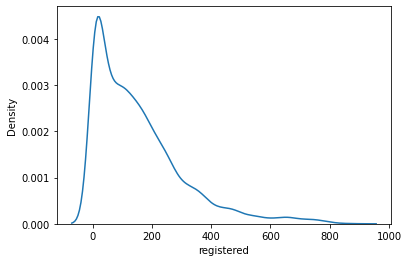

In [ ]:
sns.kdeplot(train_df['registered'])
plt.show()

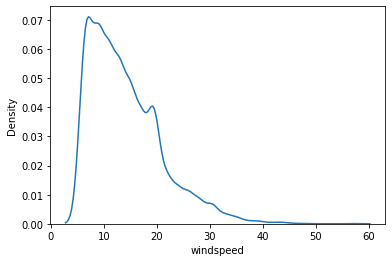

In [ ]:
sns.kdeplot((train_df['windspeed']))
plt.show()

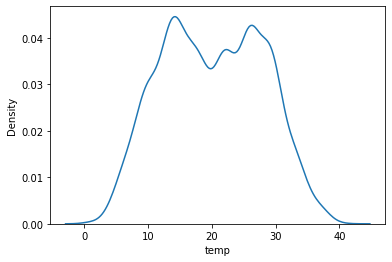

In [ ]:
sns.kdeplot((train_df['temp']))
plt.show()

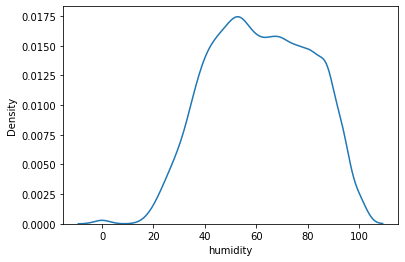

In [ ]:
sns.kdeplot((train_df['humidity']))
plt.show()

**The above four plot shows the distribution plot for the continuos features**

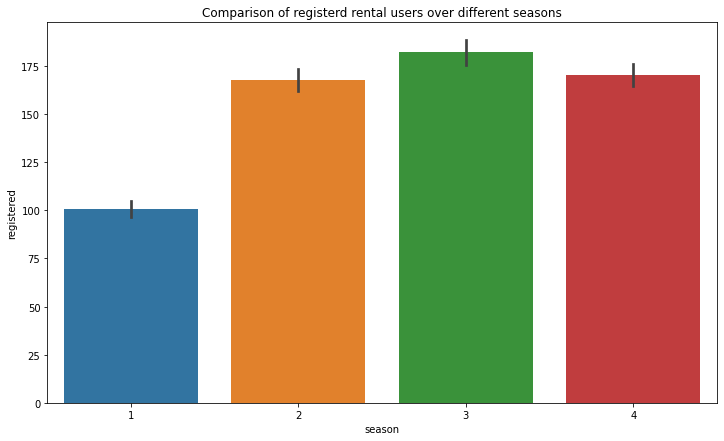

In [ ]:
fig,ax=plt.subplots(figsize=(12,7))
sns.barplot(data=train_df,x='season',y='registered',ax=ax)
plt.title('Comparison of registerd rental users over different seasons')
plt.show()

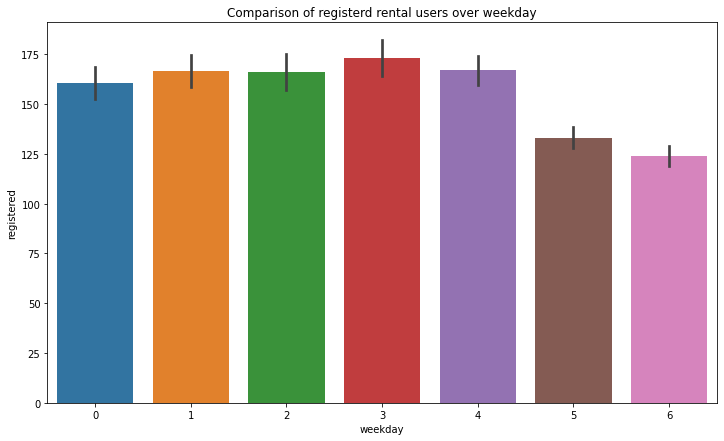

In [ ]:
fig,ax=plt.subplots(figsize=(12,7))
sns.barplot(data=train_df,x='weekday',y='registered',ax=ax)
plt.title('Comparison of registerd rental users over weekday')
plt.show()

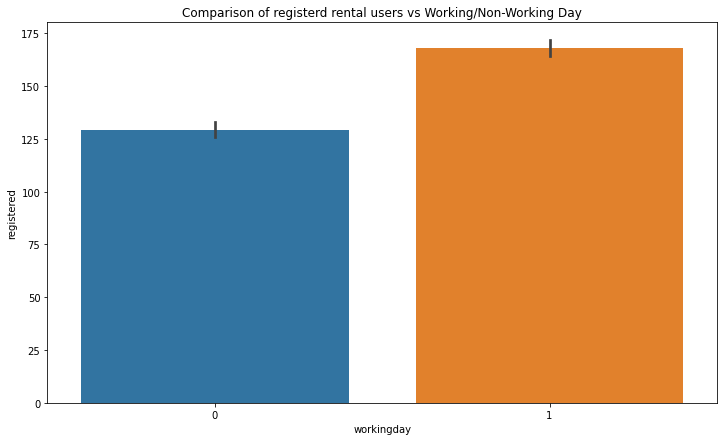

In [ ]:
fig,ax=plt.subplots(figsize=(12,7))
sns.barplot(data=train_df,x='workingday',y='registered',ax=ax)
plt.title('Comparison of registerd rental users vs Working/Non-Working Day')
plt.show()

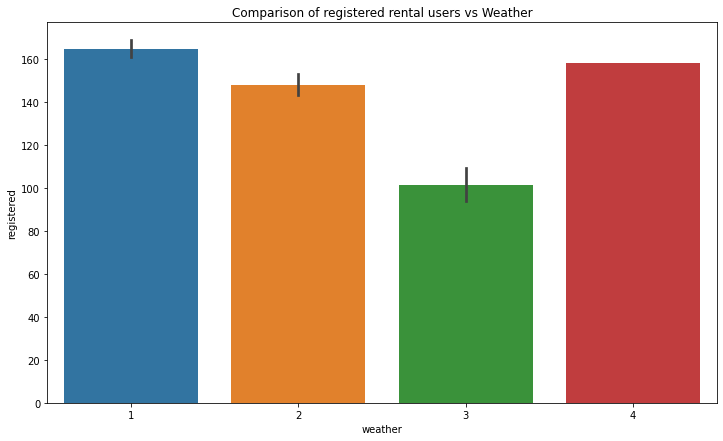

In [ ]:
fig,ax=plt.subplots(figsize=(12,7))
sns.barplot(data=train_df,x='weather',y='registered',ax=ax)
plt.title('Comparison of registered rental users vs Weather')
plt.show()

**From the above four plot we can see the variation in the number of registered rental users over season weather workingday and weekday**

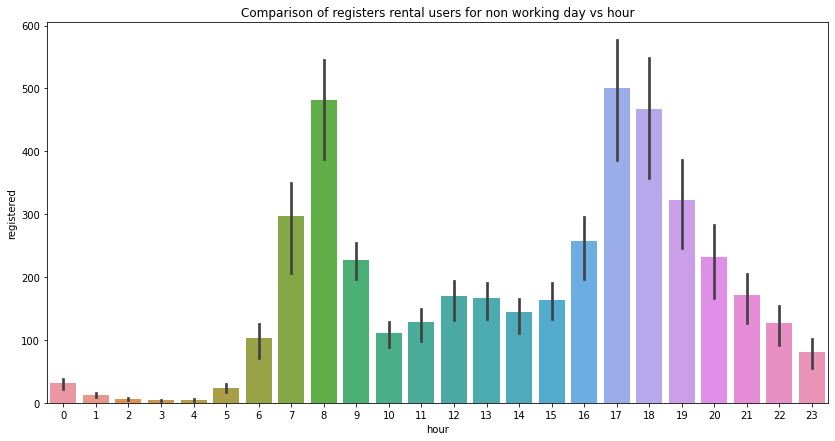

In [ ]:
fig,ax=plt.subplots(figsize=(14,7))
z=train_df.groupby(['season','workingday','weather','hour'])[['registered']].mean().reset_index()
sns.barplot(data=z[(z['workingday']==1) & (z['weather']==1)],x='hour',y='registered',ax=ax)
plt.title('Comparison of registers rental users for non working day vs hour')
plt.show()

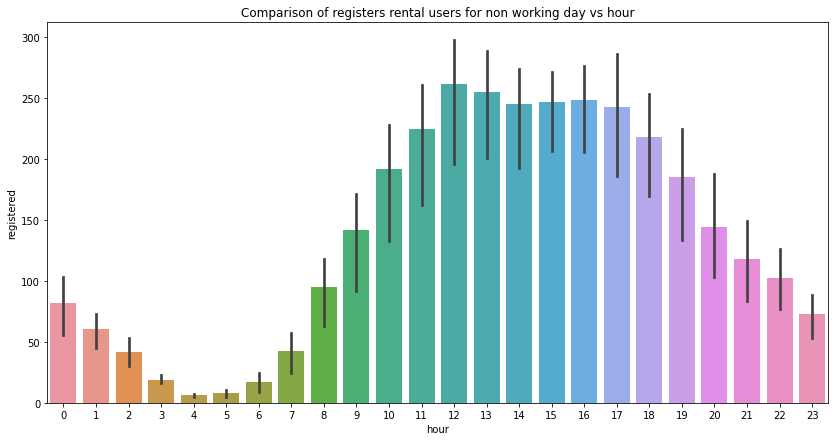

In [ ]:
fig,ax=plt.subplots(figsize=(14,7))
z=train_df.groupby(['season','workingday','weather','hour'])[['registered']].mean().reset_index()
sns.barplot(data=z[(z['workingday']==0) & (z['weather']==1)],x='hour',y='registered',ax=ax)
plt.title('Comparison of registers rental users for non working day vs hour')
plt.show()

**Now the above two plot shows the variation of registered rental users over hour for working/non-workingday**

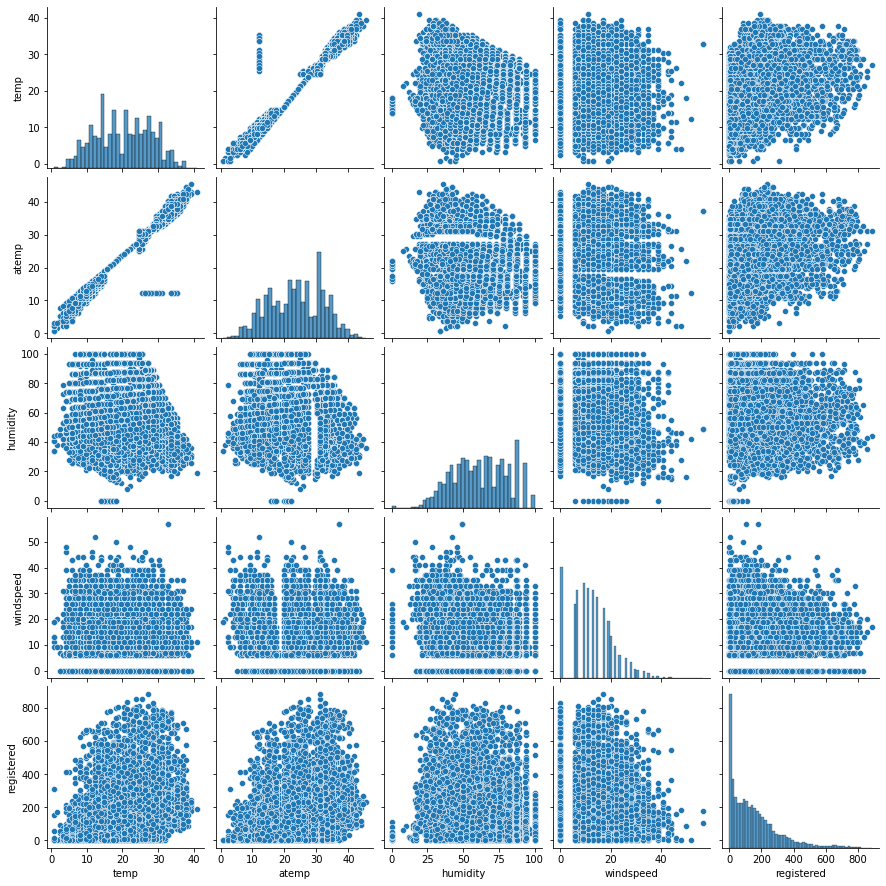

In [ ]:
sns.pairplot(train_df[['temp','atemp','humidity','windspeed','registered']])
plt.show()

**The above fig dentoes the pairplot of the features**

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

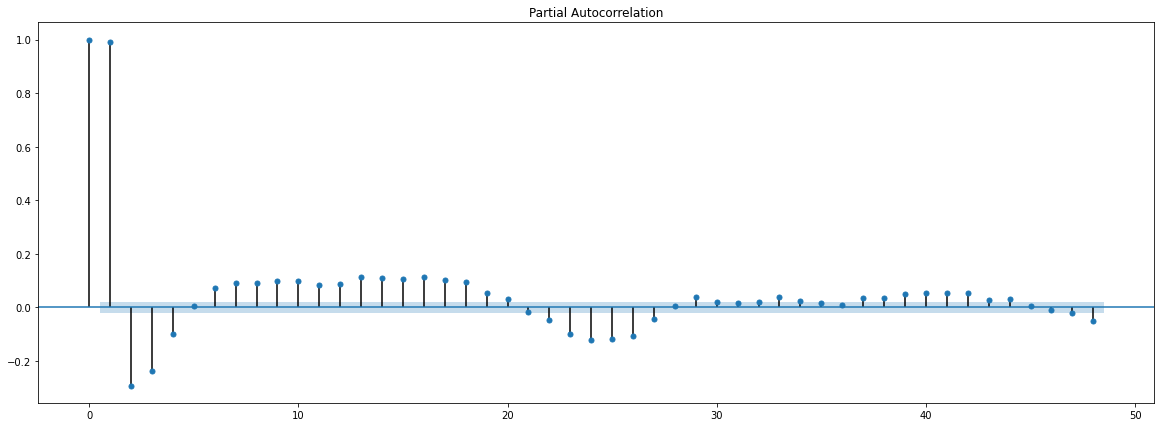

In [ ]:
fig,ax=plt.subplots(figsize=(20,7))
plot_pacf(train_df['temp'],lags=48,ax=ax)
plt.show()

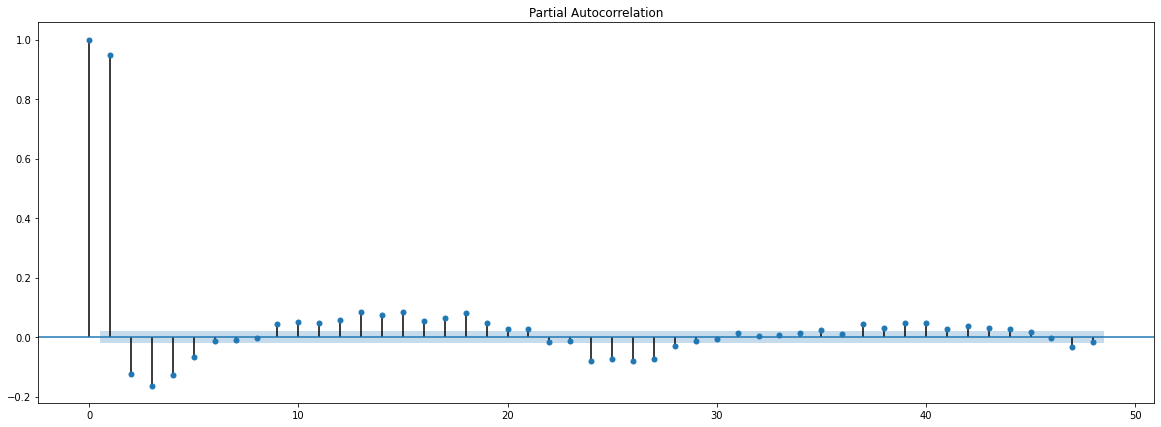

In [ ]:
fig,ax=plt.subplots(figsize=(20,7))
plot_pacf(train_df['humidity'],lags=48,ax=ax)
plt.show()

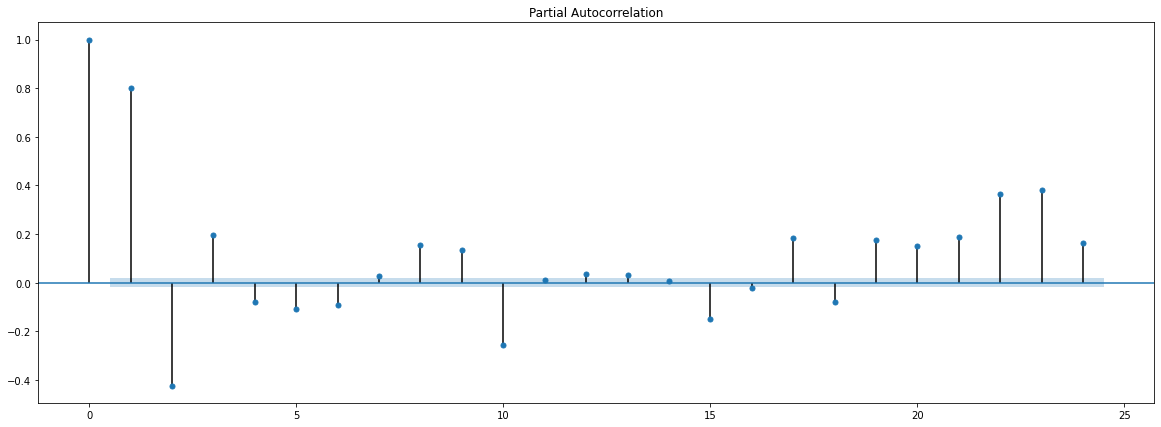

In [ ]:
fig,ax=plt.subplots(figsize=(20,7))
plot_pacf(train_df['registered'],lags=24,ax=ax)
plt.show()

**The above 3 plots contain the partial autocorrelation of the features**

**Now lets start with feature engineering from the observations of the above plot**

In [ ]:
#FEATURE ENGINEERING

In [ ]:
train_df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'hour', 'month', 'year', 'day', 'weekday'],
      dtype='object')

**Imputing 0 values in the windspeed by using model based imputation technique**

In [ ]:
wind_speed_0=train_df[train_df['windspeed']==0].drop(['datetime','casual','registered','count'],axis=1)
wind_speed_1=train_df[train_df['windspeed']!=0].drop(['datetime','casual','registered','count'],axis=1)

y_1=wind_speed_1['windspeed'].values
wind_speed_1.drop('windspeed',axis=1,inplace=True)

y_0=wind_speed_0['windspeed'].values
wind_speed_0.drop('windspeed',axis=1,inplace=True)

rf_wind_speed_fill=RandomForestRegressor(n_estimators=300)
rf_wind_speed_fill.fit(wind_speed_1,y_1)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
mean_squared_error(y_1,rf_wind_speed_fill.predict(wind_speed_1))

2.567084879428209

In [ ]:
wind_speed_0['windspeed']=rf_wind_speed_fill.predict(wind_speed_0)

In [ ]:
for ind in wind_speed_0.index:
  train_df['windspeed'][ind]=wind_speed_0['windspeed'][ind]

**Now we will create two features which will contain the busy hours and the peak hours for non-working/working day**

In [ ]:
train_df['busy_hours_non_working_day']=np.nan

In [ ]:
for ind in tqdm(list(train_df[train_df['workingday']==0].index)):
  if train_df['hour'][ind]>=8 and train_df['hour'][ind]<=20:
    train_df['busy_hours_non_working_day'][ind]=1
  else:
    train_df['busy_hours_non_working_day'][ind]=0

100%|██████████| 3474/3474 [00:00<00:00, 10365.69it/s]


In [ ]:
train_df['busy_hours_non_working_day'].fillna(0,inplace=True)

In [ ]:
train_df['busy_hours_non_working_day']=train_df['busy_hours_non_working_day'].astype(np.int32)

In [ ]:
train_df['peak_hours_working_day']=np.nan

In [ ]:
for ind in tqdm(list(train_df[train_df['workingday']==1].index)):
  if train_df['hour'][ind]>=7 and train_df['hour'][ind]<=8:
    train_df['peak_hours_working_day'][ind]=1
  elif train_df['hour'][ind]>=17 and train_df['hour'][ind]<=18:
    train_df['peak_hours_working_day'][ind]=1

  else:
    train_df['peak_hours_working_day'][ind]=0

100%|██████████| 7412/7412 [00:00<00:00, 9309.22it/s]


In [ ]:
train_df['peak_hours_working_day'].fillna(0,inplace=True)

In [ ]:
train_df['peak_hours_working_day']=train_df['peak_hours_working_day'].astype(np.int32)

**Creating lag value for the hour feature**

In [ ]:
train_df['hour_lag_value']=train_df['hour'].shift(1)
#train_df['reg_lag_value_16']=train_df['registered'].shift(16)

In [ ]:
train_df.drop(index=0,inplace=True)

**Now creating the increasing registered users feature for year 2011 and 2012**

In [ ]:
train_df['increasing_reg_users_2011']=0

In [ ]:
for ind in train_df.index:
  if train_df['month'][ind] in ([1,2,3,4,5,6]) and train_df['year'][ind]==2011:
    train_df['increasing_reg_users_2011'][ind]=1

  else:
    train_df['increasing_reg_users_2011'][ind]=0

In [ ]:
train_df['increasing_reg_users_2012']=0

In [ ]:
for ind in train_df.index:
  if train_df['month'][ind] in ([1,2,3,4,5,6]) and train_df['year'][ind]==2012:
    train_df['increasing_reg_users_2012'][ind]=1

  else:
    train_df['increasing_reg_users_2012'][ind]=0

In [ ]:
#Removing features which are posing very high correlation

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
X=train_df[['temp','humidity','windspeed','atemp']]

In [ ]:
vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Column'] = X.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Column
3,284.906959,atemp
0,261.820304,temp
1,5.910979,humidity
2,3.662893,windspeed


In [ ]:
X=train_df[['temp','humidity','windspeed']]

In [ ]:
vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Column'] = X.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Column
0,5.637837,temp
1,5.007167,humidity
2,3.662884,windspeed


In [ ]:
train_df.drop('atemp',axis=1,inplace=True)

**From the pair plot we saw that temp and atemp were having very high correlation so dropping atemp**

In [ ]:
train_df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'hour',
       'month', 'year', 'day', 'weekday', 'busy_hours_non_working_day',
       'hour_lag_value', 'peak_hours_working_day', 'increasing_reg_users_2011',
       'increasing_reg_users_2012'],
      dtype='object')

In [ ]:
a=list(train_df.columns[1:8])
b=list(train_df.columns[11:])
c=a+b

In [ ]:
c.append('registered')

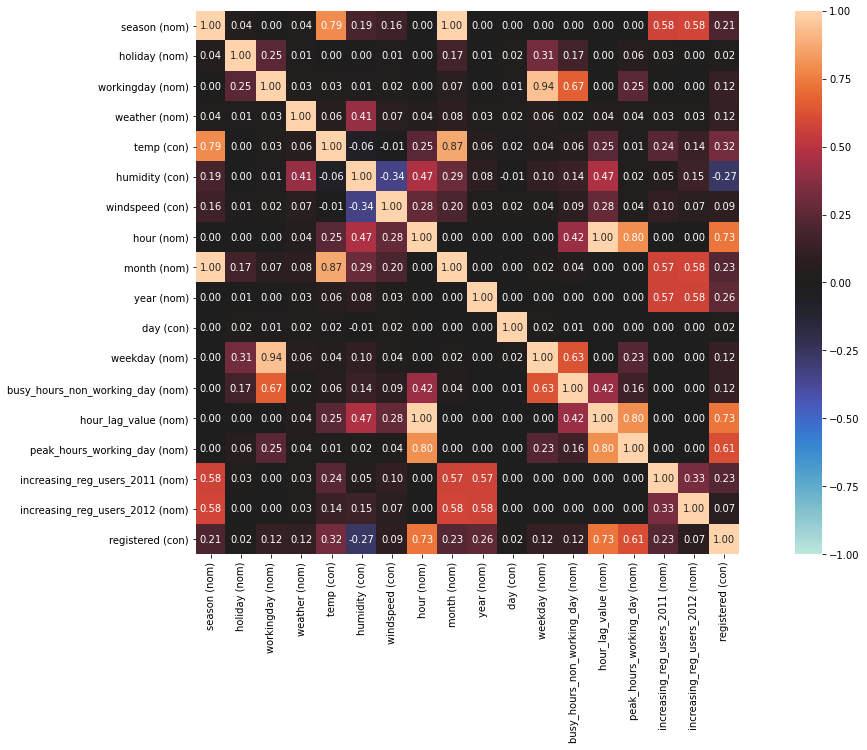

{'ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f90fd17db50>,
 'corr':                                   season (nom)  ...  registered (con)
 season (nom)                          1.000000  ...          0.210265
 holiday (nom)                         0.040460  ...          0.020971
 workingday (nom)                      0.000000  ...          0.119350
 weather (nom)                         0.035080  ...          0.115425
 temp (con)                            0.790418  ...          0.318495
 humidity (con)                        0.193534  ...         -0.265395
 windspeed (con)                       0.157014  ...          0.092080
 hour (nom)                            0.000000  ...          0.727264
 month (nom)                           0.999632  ...          0.229751
 year (nom)                            0.000000  ...          0.264201
 day (con)                             0.002252  ...          0.018971
 weekday (nom)                         0.000000  ...          0.118228
 bu

In [ ]:
nominal.associations(train_df[c],figsize=(20,10),mark_columns=True,
                     nominal_columns=['season','month','holiday','workingday','weather','peak_hours_working_day','busy_hours_non_working_day','hour','year','hour_lag_value','weekday','increasing_reg_users_2011','increasing_reg_users_2012'])

**Now the above plot is made using dython lib which calculates the correlation between categorical-categorical categorical-continuos and continuos-continuos**

In [ ]:
validation_set=train_df[(train_df['day']>=18) & (train_df['day']<=19)] 

In [ ]:
train_df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'hour',
       'month', 'year', 'day', 'weekday', 'busy_hours_non_working_day',
       'hour_lag_value', 'peak_hours_working_day', 'increasing_reg_users_2011',
       'increasing_reg_users_2012'],
      dtype='object')

**Here we will use LOFO analysis and plot to find the feature importance for the individual features**

In [ ]:
train_df.drop('datetime',axis=1,inplace=True)

In [ ]:
cat_cols=['season','holiday','workingday','weather','hour','month','year','busy_hours_non_working_day','hour_lag_value','peak_hours_working_day','day','weekday','increasing_reg_users_2011','increasing_reg_users_2012']
num_features=['temp','humidity','windspeed']

In [ ]:
#cat_cols=['season','holiday','workingday','weather','hour','month','year','day','weekday']
#num_features=['temp','humidity','windspeed']

In [ ]:
features=cat_cols+num_features

In [ ]:
train_df['registered']=np.log1p(train_df['registered'])

In [ ]:
validation_set['registered']=np.log1p(validation_set['registered'])

In [ ]:
cv=KFold(n_splits=3,random_state=0,shuffle=False)

In [ ]:
dataset=Dataset(df=train_df,target='registered',features=features)

In [ ]:
model=LGBMRegressor()

In [ ]:
lofo_imp=LOFOImportance(dataset,scoring='neg_root_mean_squared_error',model=model,cv=cv,n_jobs=-1,fit_params={"categorical_feature": cat_cols})

In [ ]:
importance_df=lofo_imp.get_importance()

  0%|          | 0/17 [00:00<?, ?it/s]

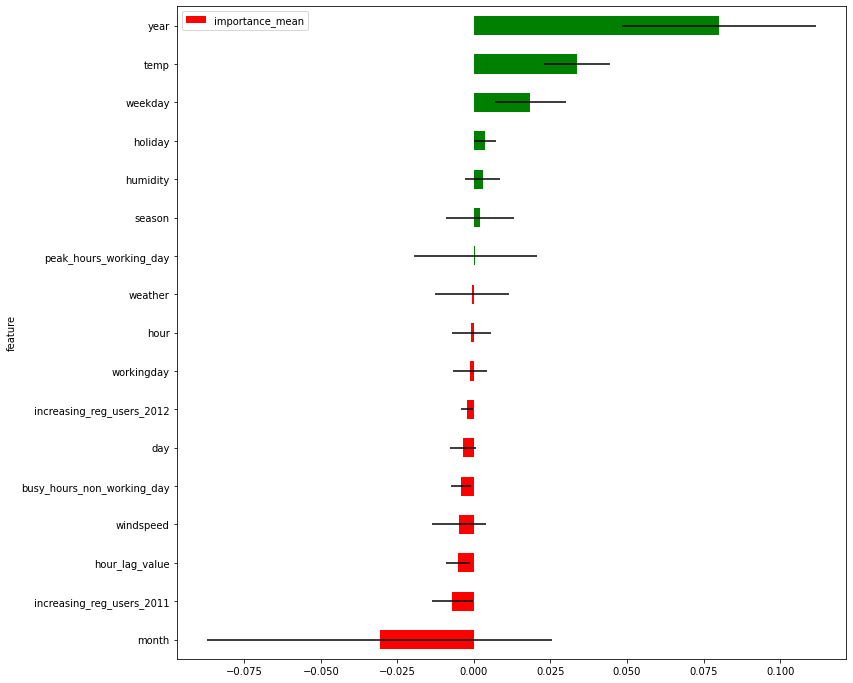

In [ ]:
plot_importance(importance_df,figsize=(12,12))

**Dropping day month and increasing reg users 2011 from both train and validation dataset**

In [ ]:
y_valid=validation_set['registered'].values
validation_set.drop(['datetime','casual','count','registered','month','day','increasing_reg_users_2011'],axis=1,inplace=True)

In [ ]:
#validation_set.drop('season',axis=1,inplace=True)

In [ ]:
train_df.drop(index=list(validation_set.index),axis=0,inplace=True)

In [ ]:
y_train=(train_df['registered'].values)
train_df.drop(['casual','count','registered','month','day','increasing_reg_users_2011'],axis=1,inplace=True)

In [ ]:
#train_df.drop('season',axis=1,inplace=True)

**Now lets start with basic hyperparameter tuning**

**1) RF-REGRESSOR**

In [ ]:
rf_params={'max_depth':[15,18,20,24,28,30,40,50,70,90,100]}

In [ ]:
rf_reg=RandomForestRegressor()

In [ ]:
rs_cv=RandomizedSearchCV(rf_reg,rf_params,n_iter=10,scoring='neg_root_mean_squared_error',n_jobs=-1,cv=3,verbose=30,random_state=21)
rs_cv.fit(train_df,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
rs_cv.best_score_

-0.5471822936028911

In [ ]:
rs_cv.best_params_

{'max_depth': 18}

In [ ]:
rf_reg_rs=RandomForestRegressor(max_depth=18,n_estimators=100)
rf_reg_rs.fit(train_df,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=18, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
y_pred_valid=rf_reg_rs.predict(validation_set)

In [ ]:
valid_rmsle_score=np.sqrt(mean_squared_error(y_valid,y_pred_valid))
valid_rmsle_score

0.31774836062100315

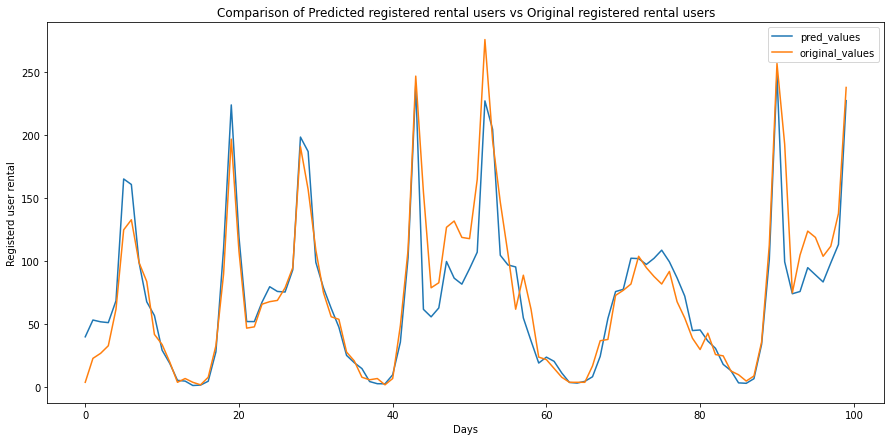

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(np.arange(100),np.exp(y_pred_valid)[:100])
plt.plot(np.arange(100),np.exp(y_valid)[:100])
plt.legend(['pred_values','original_values'])
plt.xlabel('Days')
plt.ylabel('Registerd user rental')
plt.title('Comparison of Predicted registered rental users vs Original registered rental users')
plt.show()

In [ ]:
#XGBREGRESSOR

**Here we will be using optuna to fine-tune the hyperparams for our xgbreg model**

In [ ]:
def objective(trial):

  x,y=train_df,y_train
  n_estimators=int(trial.suggest_discrete_uniform('n_estimators',1000,1200,20))
  max_depth=int(trial.suggest_discrete_uniform('max_depth',3,5,1))
  subsample=trial.suggest_uniform('subsample',0.7,0.9)
  colsample_bytree=trial.suggest_uniform('colsample_bytree',0.5,0.6)
  colsample_bylevel=trial.suggest_uniform('colsample_bylevel',0.7,0.9)

  clf=XGBRegressor(n_estimators=n_estimators,max_depth=max_depth,subsample=subsample,colsample_bytree=colsample_bytree,colsample_bylevel=colsample_bylevel)
  score=cross_val_score(clf,x,y,scoring='neg_root_mean_squared_error',n_jobs=-1,cv=3)
  rmsle_score=score.mean()

  return rmsle_score

  

In [ ]:
study=optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=30)

[I 2021-08-23 06:56:44,266] A new study created in memory with name: no-name-d33f989a-4a5a-4589-b328-51c1937dfcc6
[I 2021-08-23 06:56:52,853] Trial 0 finished with value: -0.3940525170969967 and parameters: {'n_estimators': 1160.0, 'max_depth': 3.0, 'subsample': 0.7014405333154274, 'colsample_bytree': 0.5164528479213111, 'colsample_bylevel': 0.7984470521823696}. Best is trial 0 with value: -0.3940525170969967.
[I 2021-08-23 06:57:00,869] Trial 1 finished with value: -0.39899618175218093 and parameters: {'n_estimators': 1100.0, 'max_depth': 3.0, 'subsample': 0.8446655072808843, 'colsample_bytree': 0.5256798527801196, 'colsample_bylevel': 0.8810528727409069}. Best is trial 0 with value: -0.3940525170969967.
[I 2021-08-23 06:57:11,517] Trial 2 finished with value: -0.4090509855342308 and parameters: {'n_estimators': 1100.0, 'max_depth': 4.0, 'subsample': 0.7079928225078546, 'colsample_bytree': 0.5222400083148835, 'colsample_bylevel': 0.8677489848316863}. Best is trial 0 with value: -0.394

In [ ]:
trial=study.best_trial

In [ ]:
trial.value

-0.39258016616927294

In [ ]:
trial.params

{'colsample_bylevel': 0.8312227222041053,
 'colsample_bytree': 0.5523087345299975,
 'max_depth': 3.0,
 'n_estimators': 1200.0,
 'subsample': 0.7007647460438222}

In [ ]:
xgb_reg_modified=XGBRegressor(n_estimators=1200,subsample=0.70,colsample_bytree=0.55,colsample_bylevel=0.83)
xgb_reg_modified.fit(train_df,y_train)

[07:03:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.83,
             colsample_bynode=1, colsample_bytree=0.55, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.7, verbosity=1)

In [ ]:
y_pred_valid_xgb=xgb_reg_modified.predict(validation_set)

In [ ]:
valid_rmsle_score_xgb=np.sqrt(mean_squared_error(y_valid,y_pred_valid_xgb))
print(valid_rmsle_score_xgb)

0.29068801148578005


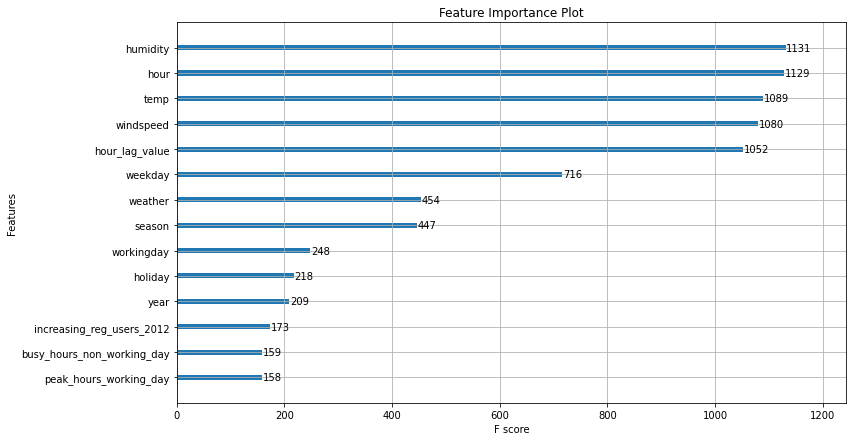

In [ ]:
fig,ax=plt.subplots(figsize=(12,7))
xgboost.plot_importance(xgb_reg_modified,ax=ax)
plt.title('Feature Importance Plot')
plt.show()

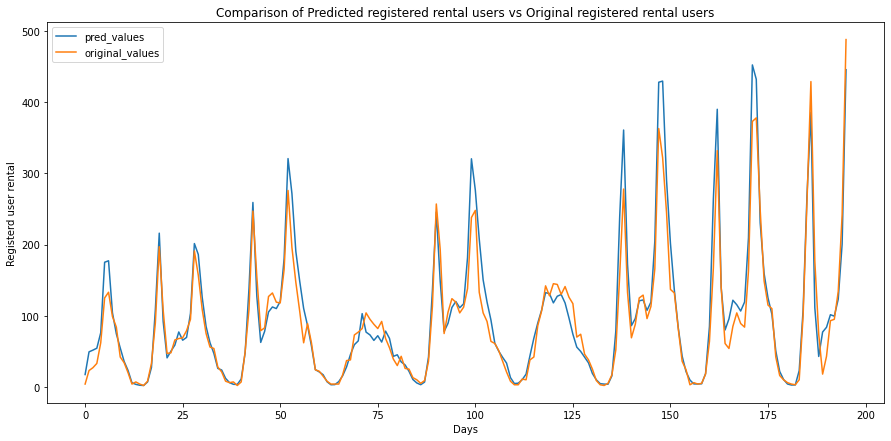

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(np.arange(196),np.exp(y_pred_valid_xgb)[:196])
plt.plot(np.arange(196),np.exp(y_valid)[:196])
plt.legend(['pred_values','original_values'])
plt.xlabel('Days')
plt.ylabel('Registerd user rental')
plt.title('Comparison of Predicted registered rental users vs Original registered rental users')
plt.show()

In [ ]:
#LIGHTGBM

**For lgb-reg model also we will use optuna for hyperparam tuning**

In [ ]:
def objective(trial):

  x,y=train_df,y_train
 # n_estimators=int(trial.suggest_discrete_uniform('n_estimators',1000,1200,20))
  max_depth=int(trial.suggest_discrete_uniform('max_depth',9,11,1))
  #subsample=trial.suggest_uniform('subsample',0.7,0.9)
  colsample_bytree=trial.suggest_uniform('colsample_bytree',0.4,0.5)
  #colsample_bylevel=trial.suggest_uniform('colsample_bylevel',0.7,0.9)

  clf=LGBMRegressor(max_depth=max_depth,colsample_bytree=colsample_bytree)
  score=cross_val_score(clf,x,y,scoring='neg_root_mean_squared_error',n_jobs=-1,cv=3)
  rmsle_score=score.mean()

  return rmsle_score

In [ ]:
study=optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=30)

[I 2021-08-23 07:24:03,744] A new study created in memory with name: no-name-74d571f4-f325-4f21-85ef-6cdb211443eb
[I 2021-08-23 07:24:05,285] Trial 0 finished with value: -0.4149001783338348 and parameters: {'max_depth': 11.0, 'colsample_bytree': 0.41633773565208726}. Best is trial 0 with value: -0.4149001783338348.
[I 2021-08-23 07:24:05,580] Trial 1 finished with value: -0.4344308224727474 and parameters: {'max_depth': 9.0, 'colsample_bytree': 0.44040407102230233}. Best is trial 0 with value: -0.4149001783338348.
[I 2021-08-23 07:24:05,901] Trial 2 finished with value: -0.4358781895110284 and parameters: {'max_depth': 11.0, 'colsample_bytree': 0.44915434040263214}. Best is trial 0 with value: -0.4149001783338348.
[I 2021-08-23 07:24:06,211] Trial 3 finished with value: -0.4351117721661555 and parameters: {'max_depth': 10.0, 'colsample_bytree': 0.4699283455459618}. Best is trial 0 with value: -0.4149001783338348.
[I 2021-08-23 07:24:06,513] Trial 4 finished with value: -0.435878189511

In [ ]:
trial=study.best_trial

In [ ]:
trial.value

-0.4149001783338348

In [ ]:
trial.params

{'colsample_bytree': 0.41633773565208726, 'max_depth': 11.0}

In [ ]:
lgb_reg_modified=LGBMRegressor(n_estimators=100,max_depth=11,colsample_bytree=0.416)
lgb_reg_modified.fit(train_df,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.416,
              importance_type='split', learning_rate=0.1, max_depth=11,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
y_pred_valid_lgbm=lgb_reg_modified.predict(validation_set)

In [ ]:
valid_rmsle_score_lgbm=np.sqrt(mean_squared_error(y_valid,y_pred_valid_lgbm))
valid_rmsle_score_lgbm

0.29083830859384047

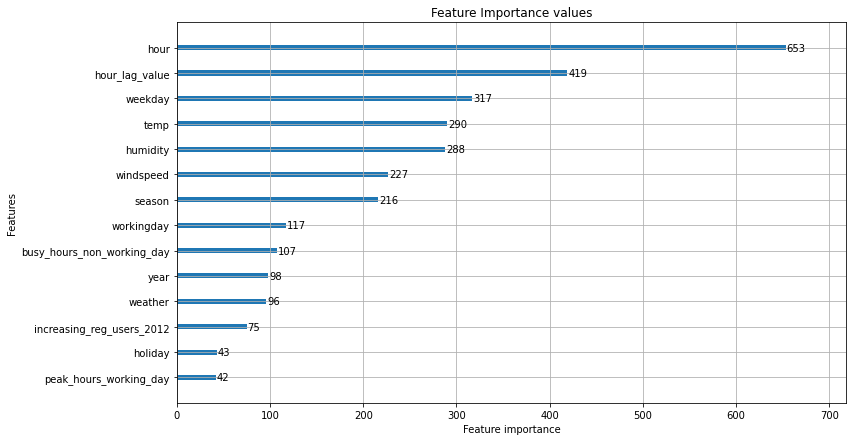

In [ ]:
fig,ax=plt.subplots(figsize=(12,7))
lightgbm.plot_importance(lgb_reg_modified,ax=ax)
plt.title('Feature Importance values')
plt.show()

In [ ]:
y_pred_valid_org_lgbm=np.exp(y_pred_valid_lgbm)

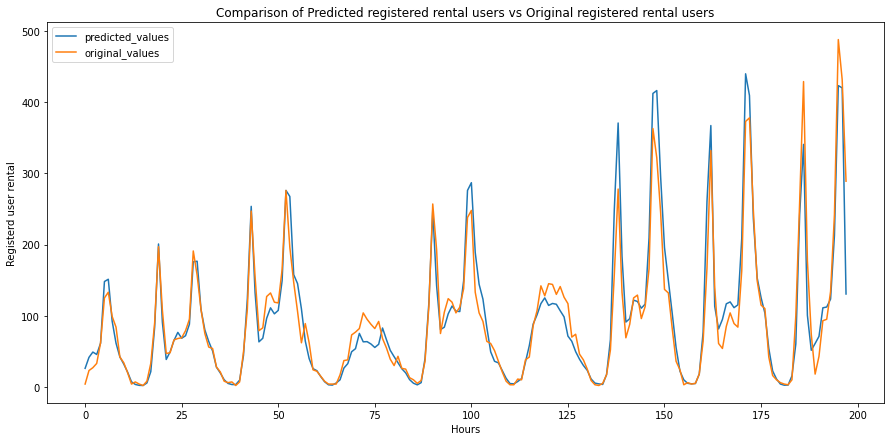

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(np.arange(198),y_pred_valid_org_lgbm[:198])
plt.plot(np.arange(198),np.exp(y_valid)[:198])
plt.legend(['predicted_values','original_values'])
plt.xlabel('Hours')
plt.ylabel('Registerd user rental')
plt.title('Comparison of Predicted registered rental users vs Original registered rental users')
plt.show()

**Now lets predict on the test set**

In [ ]:
test_df=pd.read_csv('/content/drive/MyDrive/test_bk.csv')

In [ ]:
test_df['datetime']=pd.to_datetime(test_df['datetime'])

In [ ]:
test_df['hour']=test_df['datetime'].dt.hour
test_df['month']=test_df['datetime'].dt.month
test_df['year']=test_df['datetime'].dt.year
test_df['day']=test_df['datetime'].dt.day
test_df['weekday']=test_df['datetime'].dt.weekday

In [ ]:
test_df['busy_hours_non_working_day']=np.nan

In [ ]:
for ind in tqdm(list(test_df[test_df['workingday']==0].index)):
  if test_df['hour'][ind]>=8 and test_df['hour'][ind]<=20:
    test_df['busy_hours_non_working_day'][ind]=1
  else:
    test_df['busy_hours_non_working_day'][ind]=0

100%|██████████| 2040/2040 [00:00<00:00, 10137.19it/s]


In [ ]:
test_df['busy_hours_non_working_day'].fillna(0,inplace=True)

In [ ]:
test_df['busy_hours_non_working_day']=test_df['busy_hours_non_working_day'].astype(np.int32)

In [ ]:
test_df['hour_lag_value']=test_df['hour'].shift(1)

In [ ]:
test_df['hour_lag_value'].fillna(23.0,inplace=True)

In [ ]:
test_df['peak_hours_working_day']=np.nan

In [ ]:
for ind in tqdm(list(test_df[test_df['workingday']==1].index)):
  if test_df['hour'][ind]>=7 and test_df['hour'][ind]<=8:
    test_df['peak_hours_working_day'][ind]=1
  elif test_df['hour'][ind]>=17 and test_df['hour'][ind]<=18:
    test_df['peak_hours_working_day'][ind]=1

  else:
    test_df['peak_hours_working_day'][ind]=0

100%|██████████| 4453/4453 [00:00<00:00, 9978.75it/s]


In [ ]:
test_df['peak_hours_working_day'].fillna(0,inplace=True)

In [ ]:
test_df['peak_hours_working_day']=test_df['peak_hours_working_day'].astype(np.int32)

In [ ]:
wind_speed_0=test_df[test_df['windspeed']==0].drop(['datetime'],axis=1)
wind_speed_1=test_df[test_df['windspeed']!=0].drop(['datetime'],axis=1)

y_1=wind_speed_1['windspeed'].values
wind_speed_1.drop('windspeed',axis=1,inplace=True)

y_0=wind_speed_0['windspeed'].values
wind_speed_0.drop('windspeed',axis=1,inplace=True)

rf_wind_speed_fill=RandomForestRegressor(n_estimators=300)
rf_wind_speed_fill.fit(wind_speed_1,y_1)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
wind_speed_0['windspeed']=rf_wind_speed_fill.predict(wind_speed_0)

In [ ]:
for ind in wind_speed_0.index:
  test_df['windspeed'][ind]=wind_speed_0['windspeed'][ind]

In [ ]:
test_df['increasing_reg_users_2011']=0

In [ ]:
for ind in test_df.index:
  if test_df['month'][ind] in [1,2,3,4,5,6] and test_df['year'][ind]==2011:
    test_df['increasing_reg_users_2011'][ind]=1 

  else:
    test_df['increasing_reg_users_2011'][ind]=0


In [ ]:
test_df['increasing_reg_users_2012']=0

In [ ]:
for ind in test_df.index:
  if test_df['month'][ind] in [1,2,3,4,5,6,7,8,9,10] and test_df['year'][ind]==2012:
    test_df['increasing_reg_users_2012'][ind]=1 

  else:
    test_df['increasing_reg_users_2012'][ind]=0

In [ ]:
datetime=test_df['datetime'].values

In [ ]:
test_df.drop(['datetime'],axis=1,inplace=True)

In [ ]:
test_df.drop(['atemp'],axis=1,inplace=True)

In [ ]:
test_df.drop(['month','day','increasing_reg_users_2011'],axis=1,inplace=True)

**Saving all the 3 models so that we can use it for making final predictions**

In [ ]:
my_file=open('xgb_reg_model.txt','wb')
pickle.dump(xgb_reg_modified,my_file)
my_file.close()

In [ ]:
my_file=open('lgb_reg_model.txt','wb')
pickle.dump(lgb_reg_modified,my_file)
my_file.close()

In [ ]:
my_file=open('rf_reg_model.txt','wb')
pickle.dump(rf_reg_rs,my_file)
my_file.close()

In [ ]:
import pickle

In [ ]:
test_df=pd.read_csv('/content/drive/MyDrive/test_df.csv')

In [ ]:
my_file_1=open('/content/drive/MyDrive/xgb_reg_model (1).txt','rb')
xgb_reg_model=pickle.load(my_file_1)

my_file_2=open('/content/drive/MyDrive/lgb_reg_model.txt','rb')
lgb_reg_model=pickle.load(my_file_2)

my_file_3=open('/content/drive/MyDrive/rf_reg_model.txt','rb')
rf_reg_model=pickle.load(my_file_3)

[11:18:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


**Here we are predicting the final readings using our 3 models above**

In [ ]:
final_pred_org_1=np.expm1(xgb_reg_model.predict(test_df))
final_pred_org_2=np.expm1(lgb_reg_model.predict(test_df))
final_pred_org_3=np.expm1(rf_reg_model.predict(test_df))

**For final readings I am combining the readings from the above 3 models**

In [ ]:
final_pred_org=(final_pred_org_1*0.85+final_pred_org_2*0.1+final_pred_org_3*0.01)

In [ ]:
final_df_reg_users=pd.DataFrame({'datetime':datetime,'reg_users':(final_pred_org)})

In [ ]:
#final_df_reg_users=pd.DataFrame({'datetime':datetime,'reg_users':(final_pred_org_1*0.85+final_pred_org_2*0.08+)})

In [ ]:
final_df_reg_users.to_csv('final_df_reg_users_74.csv',index=False)